In [532]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [533]:
"""
def knn_graph(Data, method, k):
    # 获取样本点的数量
    n = Data.shape[0]
    print("样本点的数量：", n)
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(n, distances): 
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

# 以将距离从小到大排序后的第k个距离作为每个数据点的半径
def compute_k_maximun_radius(n, distances, k):
    radius = np.zeros(n)
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    for i in range(n):
        # 选取第k个距离作为半径
        radius[i] = sorted_distances[i, k]
    return radius

# 计算k最近邻接矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_k_maximun_radius(n, distances, k)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 获取epsilon邻域内的样本索引
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, k, t):
    n = len(Data)
    print("样本点的数量：", n)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    # 计算相似度矩阵
    similarity_matrix = np.exp(-distances ** 2 / t)
    # 将相似度矩阵按照邻接矩阵进行筛选，得到需要设置权重的位置
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    # 设置权重
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]  # 对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix   


def LPP(Data, d, method, k, t):
    # Step 1: 计算权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    print("权重矩阵形状：", Weight_matrix.shape)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    print("度矩阵形状：", Degree_matrix.shape)
    Laplacian_matrix = Degree_matrix - Weight_matrix
    print("拉普拉斯矩阵形状：", Laplacian_matrix.shape)
    # Step 3: 进行特征映射
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors
"""

'\ndef knn_graph(Data, method, k):\n    # 获取样本点的数量\n    n = Data.shape[0]\n    print("样本点的数量：", n)\n    # 初始化k近邻图的邻接矩阵\n    knn_adjacency_matrix = np.zeros((n, n))  \n    # 计算欧式距离矩阵\n    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))\n    if method == \'epsilon\':\n        return knn_adjacency_matrix, distances\n    # 获取每个样本点的最近邻索引\n    indices = np.argsort(distances, axis=1)[:, 1:k+1]\n    # 构建k近邻图的权重矩阵\n    # 遍历每个样本点的最近邻索引\n    for i in range(n):\n        knn_adjacency_matrix[i, indices[i]] = 1\n        knn_adjacency_matrix[indices[i], i] = 1\n    return knn_adjacency_matrix, distances\n\n# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径\ndef compute_avg_radius(n, distances): \n    radius = np.zeros(n) # 存储每个数据点的平均邻域半径\n    for i in range(n): # 计算每个数据点的平均邻域半径\n        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值\n        radius[i] = avg_radius # 存储每个数据点的平均邻域半径\n    return radius\n\n# 以将距离从小到大排序后的第k个距离作为每个数据点的半径\ndef compute_k_maximun_radius(n, distances, k):\n    radius = np.z

In [534]:
"""
def knn_graph(Data, method, k):
    n = Data.shape[1]  # 修改此处获取样本点的数量
    knn_adjacency_matrix = np.zeros((n, n))  
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1)) 
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances
"""

def compute_adaptive_k(Data, threshold):
    n = Data.shape[1]  # 修改此处获取样本点的数量
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1)) 
    #np.savetxt('distances.csv', distances, delimiter=',')  # 保存距离矩阵
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    #np.savetxt('sorted_distances.csv', sorted_distances, delimiter=',')  # 保存排序后的距离矩阵
    # 找出sorted_distances每一行的前一列与后一列距离之差第一次小于阈值的位置并保存为一个列矩阵
    adaptive_k = np.zeros((n, 1))
    for i in range(n):
        for j in range(1, n-1):
            if (sorted_distances[i, j+1] - sorted_distances[i, j])  < threshold:
                adaptive_k[i] = j
                break           
    #np.savetxt('adaptive_k.csv', adaptive_k, delimiter=',')  # 保存index
    #对列矩阵index求平均
    index_mean = np.mean(adaptive_k)
    return adaptive_k, sorted_distances, distances, index_mean

# 根据adaptive_k中每一行的k值和sorted_distances对每个数据点构建knn graph
def adaptive_knn_graph(Data, threshold):
    adaptive_k, sorted_distances, distances, index_mean = compute_adaptive_k(Data, threshold)
    n = Data.shape[1]  # 修改此处获取样本点的数量
    knn_adjacency_matrix = np.zeros((n, n))  
    for i in range(n):
        indices = np.argsort(sorted_distances[i])[:int(adaptive_k[i])]
        knn_adjacency_matrix[i, indices] = 1
        knn_adjacency_matrix[indices, i] = 1
    return knn_adjacency_matrix, distances, index_mean

def compute_avg_radius(n, distances): 
    radius = np.zeros(n)
    for i in range(n):
        avg_radius = np.mean(distances[:, i])  # 修改计算每个数据点的平均邻域半径的方式
        radius[i] = avg_radius
    return radius

def compute_knn_average_radius(distances, k):
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    avg_knn_distances = np.mean(sorted_distances[:, 1:k+1], axis=1)  # 计算每个数据点的前k个距离的平均值作为半径
    return avg_knn_distances

def compute_neighborhood_matrix(Data, method, threshold):
    n = Data.shape[1]  # 修改获取样本点的数量的方式
    knn_adjacency_matrix, distances, index_mean = adaptive_knn_graph(Data, threshold)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    adjacency_matrix = np.zeros((n, n))
    radius = compute_knn_average_radius(distances, index_mean)
    for i in range(n):
        neighbors = np.where(distances[:, i] <= radius[i])[0]  # 修改获取epsilon邻域内的样本索引的方式
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1
    return adjacency_matrix, distances

def construct_weight_matrix(Data, method, threshold, t):
    n = Data.shape[1]  # 修改获取样本点的数量的方式
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, threshold)
    similarity_matrix = np.exp(-distances ** 2 / t)
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix

def LPP(Data, d, method, threshold, t):
    Weight_matrix = construct_weight_matrix(Data, method, threshold, t)
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    objective_value = np.dot(np.dot(Data, Laplacian_matrix), Data.T)  # 计算目标函数
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1)
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors


In [535]:
# 读取数据集
def read_images(dataset_dir, target_size=(32, 32)):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 缩放图像至目标尺寸
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    train_samples = int(num_samples * train_test_split_ratio)  # 训练集样本数
    
    # 洗牌算法打乱数据集
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # 划分训练集和测试集
    train_data = data[:train_samples]
    train_labels = labels[:train_samples]
    test_data = data[train_samples:]
    test_labels = labels[train_samples:]
    
    return train_data, train_labels, test_data, test_labels

In [536]:
def ShowEigenface(eigenfaces, faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    #print("显示特征脸")
    plt.show()

In [537]:
# 读取人脸图像
faces, classes, faceshape = read_images("ORL")  # 读取图像数据和标签

train_data, train_labels, test_data, test_labels = train_test_split(faces, classes, 0.7)  # 划分训练集和测试集
# 打印一些细节
print("人脸图像形状:", faceshape)
print("类别数量:", len(classes))
print("图像数量:", len(faces))
print("测试集标签形状:", test_labels.shape)

人脸图像形状: (32, 32)
类别数量: 400
图像数量: 400
测试集标签形状: (120, 1)


训练集形状： (1024, 280)
平均人脸形状: (1024, 1)


C:\Users\Tony\AppData\Local\Temp\ipykernel_14408\1965882705.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices = np.argsort(sorted_distances[i])[:int(adaptive_k[i])]


特征脸形状: (1024, 70)
权重矩阵形状: (70, 280)


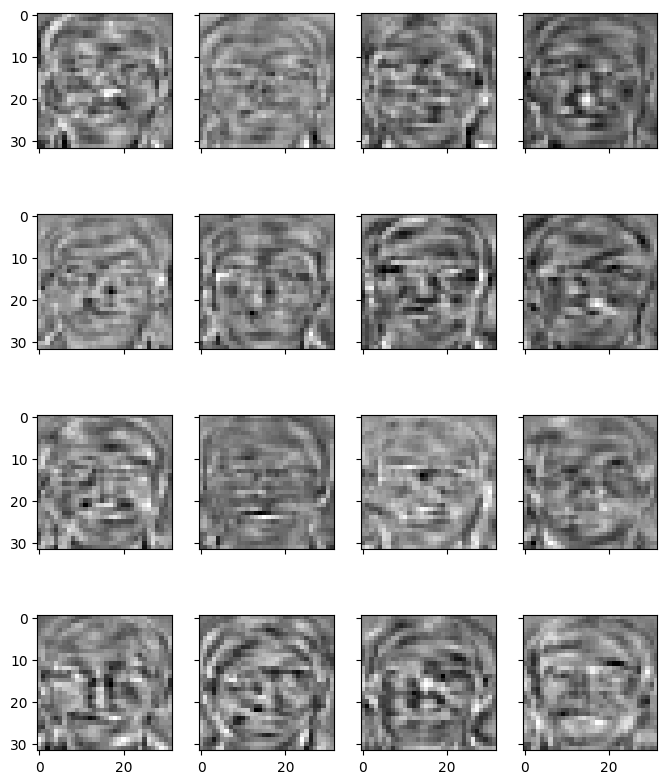

In [538]:
# 应用LPP并选择前K个主成分作为特征脸

d = 70
threshold = 0.05
t = 87250
method = 'knn'

train_data = train_data.T
print("训练集形状：", train_data.shape)

overall_mean = np.mean(train_data , axis=1).reshape(-1, 1)
print("平均人脸形状:", overall_mean.shape)

#既是特征脸，又是transformation matrix A
lpp_eigenfaces = LPP(train_data, d, method, threshold, t)
print("特征脸形状:", lpp_eigenfaces.shape)

#既是权重矩阵，又是Y
lpp_weight_matrix = lpp_eigenfaces.T @ (train_data-overall_mean) 
print("权重矩阵形状:", lpp_weight_matrix.shape)

ShowEigenface(lpp_eigenfaces, faceshape)

In [539]:
def test_image(i, faceshape, overall_mean, train_labels, test_labels, train_data, test_data, lpp_eigenfaces, lpp_weight_matrix):
    # 计算测试图像的权重向量
    #print("测试图像形状:", query.shape)
    #print("平均人脸形状:", overall_mean.shape)
    #print("特征脸形状:", dlpp_eigenfaces.shape)
    query = test_data[i]
    query_weight = (lpp_eigenfaces.T @ (query - overall_mean.flatten()).reshape(-1, 1))
    # 计算测试图像与数据集中每个人脸的欧氏距离
    euclidean_distances = np.linalg.norm(lpp_weight_matrix - query_weight, axis=0)
    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    #判断是否匹配正确
    flag = False
    if train_labels[best_match_index] == test_labels[i]:
        flag = True
    else:
        flag = False
    """
    # 可视化
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
    axes[0].imshow(query.reshape(faceshape), cmap="gray")
    axes[0].set_title("Query Image")
    axes[1].set_xlabel("Euclidean Distance: {:.0f}".format(euclidean_distances[best_match_index]))
    axes[1].imshow(train_data[best_match_index].reshape(faceshape), cmap="gray")
    axes[1].set_title("Best Match")
    plt.show()
    """
    return flag


# 单次识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_image(i, faceshape, overall_mean, train_labels, test_labels, train_data, test_data, lpp_eigenfaces, lpp_weight_matrix)
    if flag:
                right_times += 1
    else:
        wrong_times += 1
rate = right_times / test_data.shape[0]
print(f"Recognition Rate: {rate}")


'\n# 识别率统计\nwrong_times = 0\nright_times = 0\nfor i in range(test_data.shape[0]):\n    flag = test_image(i, faceshape, overall_mean, train_labels, test_labels, train_data, test_data, lpp_eigenfaces, lpp_weight_matrix)\n    if flag:\n                right_times += 1\n    else:\n        wrong_times += 1\nrate = right_times / test_data.shape[0]\nprint(f"Recognition Rate: {rate}")\n'

In [540]:
# 求平均识别率
times = 100
rates = []
for i in range(times):
    overall_mean = np.mean(train_data , axis=1).reshape(-1, 1)
    lpp_eigenfaces = LPP(train_data, d, method, threshold, t)
    lpp_weight_matrix = lpp_eigenfaces.T @ (train_data-overall_mean)
    wrong_times = 0
    right_times = 0
    for i in range(test_data.shape[0]):
        flag = test_image(i, faceshape, overall_mean, train_labels, test_labels, train_data, test_data, lpp_eigenfaces, lpp_weight_matrix)
        if flag:
                    right_times += 1
        else:
            wrong_times += 1
    rate = right_times / test_data.shape[0]
    rates.append(rate)
print(f"Average Recognition Rate: {np.mean(rates)}")
    


C:\Users\Tony\AppData\Local\Temp\ipykernel_14408\1965882705.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices = np.argsort(sorted_distances[i])[:int(adaptive_k[i])]


Average Recognition Rate: 0.95
